# Модель классификации комментариев с BERT

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

# Цель

Обучить модель классифицировать комментарии на позитивные и негативные.

# Загрузка данных

In [1]:
!pip install torch -q
!pip install transformers -q
!pip install lightgbm==3.3.1 -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
df = pd.read_csv('toxic_comments.csv', sep=',')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


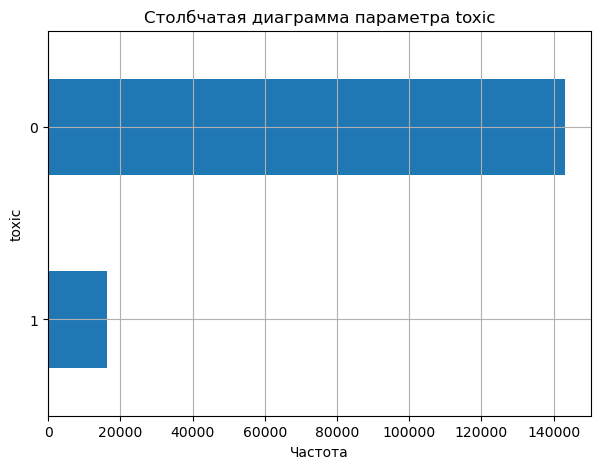

In [4]:
def barh(ser):
    ser.value_counts(ascending=True).plot.barh(figsize=(7,5), grid=True)
    plt.title("Столбчатая диаграмма параметра "+ser.name)
    plt.xlabel("Частота")
    plt.ylabel(ser.name)
    
barh(df['toxic'])  

Видно, что токсичных комментариев значительно меньше.

# Эмбидинги

In [5]:
df = df.sample(10000, random_state=RANDOM_STATE)

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [6]:
model_emb = AutoModel.from_pretrained("unitary/toxic-bert")

In [7]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_emb(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
features = np.concatenate(embeddings)

# Моделирование

In [9]:
X = features
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)

## LogisticRegression

In [10]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')

parameters = {
    'C': range(1, 50)
}

rs_lr = RandomizedSearchCV(
    model,
    parameters,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=5,
    scoring='f1')

rs_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs_lr.best_estimator_)
print ('Метрика f1 лучшей модели на кросс-валидации:', rs_lr.best_score_)

Лучшая модель и её параметры:

 LogisticRegression(C=14, random_state=42, solver='liblinear')
Метрика f1 лучшей модели на кросс-валидации: 0.9356456383724044


## DecisionTreeClassifier

In [11]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'min_samples_leaf': range(1, 15),
    'max_depth': range(2, 15),
    'min_samples_split': range(2, 15)
}

rs_dtc = RandomizedSearchCV(
    model,
    parameters,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=5,
    scoring='f1')

rs_dtc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs_dtc.best_estimator_)
print('Метрика f1 лучшей модели на кросс-валидации:', rs_dtc.best_score_)

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, min_samples_split=7,
                       random_state=42)
Метрика f1 лучшей модели на кросс-валидации: 0.9254518985843084


## KNeighborsClassifier

In [12]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(5, 50)
}

gs_knc = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring='f1')

gs_knc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_knc.best_estimator_)
print ('Метрика f1 лучшей модели на кросс-валидации:', gs_knc.best_score_)

Лучшая модель и её параметры:

 KNeighborsClassifier(n_neighbors=15)
Метрика f1 лучшей модели на кросс-валидации: 0.9513278933065639


## SVC

In [13]:
model = SVC()

parameters = {
    'kernel': ['linear', 'sigmoid', 'rbf', 'poly'],
    'degree': range(1, 5),
    'C': [0.1,1,10,100]
}

gs_svc = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,    
    cv=5,
    scoring='f1')

gs_svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_svc.best_estimator_)
print ('Метрика f1 лучшей модели на кросс-валидации:', gs_svc.best_score_)

Лучшая модель и её параметры:

 SVC(C=10, degree=1, kernel='poly')
Метрика f1 лучшей модели на кросс-валидации: 0.9521077925571054


# Анализ

Наилучший результат продемонстрировала модель SVC.

In [14]:
y_pred = gs_svc.predict(X_test)
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_pred)}')

Метрика F1 на тестовой выборке: 0.9646182495344506
